In [7]:
%reload_ext autoreload
%autoreload 2

In [8]:
import logging
import os

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Set background and fontsize
rc_params = {
    "pdf.fonttype": 42,  # Make fonts editable in Adobe Illustrator
    "ps.fonttype": 42,  # Make fonts editable in Adobe Illustrator
    "axes.labelcolor": "#222222",
    "axes.labelsize": 9,
    "text.color": "#222222",
    "font.sans-serif": "Helvetica",
    "text.usetex": False,
    "figure.figsize": (7.2, 4.45),
    "xtick.major.size": 0.00,
    "ytick.major.size": 0.00,
    "axes.labelpad": 0.1,
}
sns.set(style="white", context="paper", rc=rc_params, font_scale=1.0)

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)


In [9]:
STATE_COLORS = {
    "stationary": "#9f043a",
    "fragmented": "#ff6944",
    "continuous": "#521b65",
    "stationary-continuous-mix": "#61c5e6",
    "fragmented-continuous-mix": "#2a586a",
    "": "#c7c7c7",
}


def plot_classification(replay_time, test_spikes, results):
    fig, axes = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=True, sharex=True)
    spike_time_ind, neuron_ind = np.nonzero(test_spikes)
    axes[0].scatter(replay_time[spike_time_ind], neuron_ind, color='black', zorder=1,
                    marker='|', s=80, linewidth=3)
    axes[0].set_yticks((0, test_spikes.shape[1]))
    axes[0].set_ylabel('Neuron Index')
    replay_probabilities = results.groupby("state").sum().acausal_posterior
    for state in replay_probabilities.state.values:
        replay_probabilities.sel(state=state).plot(x='time', color=STATE_COLORS[state], linewidth=3,
                         ax=axes[1], label=state)
    axes[1].set_ylabel('Probability')
    axes[1].set_yticks([0, 1])
    axes[1].set_ylim((-0.01, 1.05))
    axes[1].legend(bbox_to_anchor=(1.15, 0.95), loc='upper right', fancybox=False, shadow=False,
                   ncol=1, frameon=False)
    
    results.acausal_posterior.groupby("position").sum().plot(
        x='time', y='position', robust=True, vmin=0.0, ax=axes[2])
    axes[2].set_ylabel('Position [cm]')
    plt.xlim((replay_time.min(), replay_time.max()))
    axes[-1].set_xlabel('Time [ms]')
    sns.despine()


In [10]:
from replay_trajectory_classification.sorted_spikes_simulation import (
    make_simulated_run_data,
)

(
    time,
    linear_distance,
    sampling_frequency,
    spikes,
    place_fields,
) = make_simulated_run_data()


In [11]:
from replay_trajectory_classification import (
    SortedSpikesClassifier,
    estimate_movement_var,
    Environment,
    RandomWalk,
    Uniform,
    Identity,
)


movement_var = estimate_movement_var(linear_distance, sampling_frequency)

environment = Environment(place_bin_size=np.sqrt(movement_var))
continuous_transition_types = [
    [RandomWalk(movement_var=movement_var * 120), Uniform(), Identity()],
    [Uniform(), Uniform(), Uniform()],
    [RandomWalk(movement_var=movement_var * 120), Uniform(), Identity()],
]

classifier = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
)

classifier


SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='',
                                                                movement_var=33.31009971953084,
                                                                movement_mean=0.0,
                                                                use_diffusion=False),
                                                     Uniform(environment_name='',
                                                             environment2_name=None),
                                                     Identity(environment_name='')],
                                                    [Uniform(environment_name='',
                                                             environment2_name=None),
                                                     Uniform(environment_name='',
                                                             environment2_name=None),
                                                     Uniform(...
                       initial_conditions_type=UniformInitialConditions(),
                       observation_models=(ObservationModel(environment_name='',
                                                            encoding_group=0),
                                           ObservationModel(environment_name='',
                                                            encoding_group=0),
                                           ObservationModel(environment_name='',
                                                            encoding_group=0)),
                       sorted_spikes_algorithm='spiking_likelihood_kde',
                       sorted_spikes_algorithm_params={'block_size': None,
                                                       'position_std': 6.0,
                                                       'use_diffusion': False})

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting continuous state transition...
INFO:replay_trajectory_classification.classifier:Fitting discrete state transition
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/19 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:iteration 0, likelihood: -339.6042785644531
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:iteration 1, likelihood: -332.36773681640625, change: 7.236541748046875
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:iteration 2, likelihood: -332.08099365234375, change: 0.2867431640625
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_

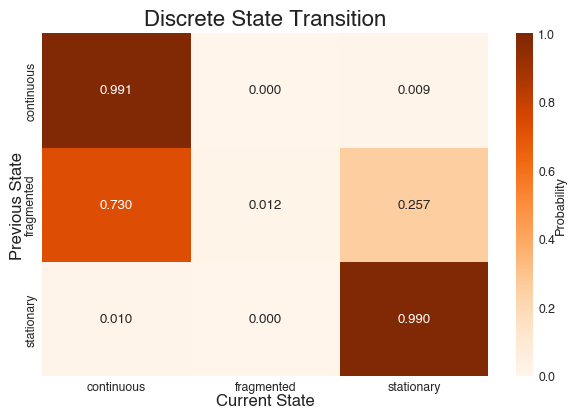

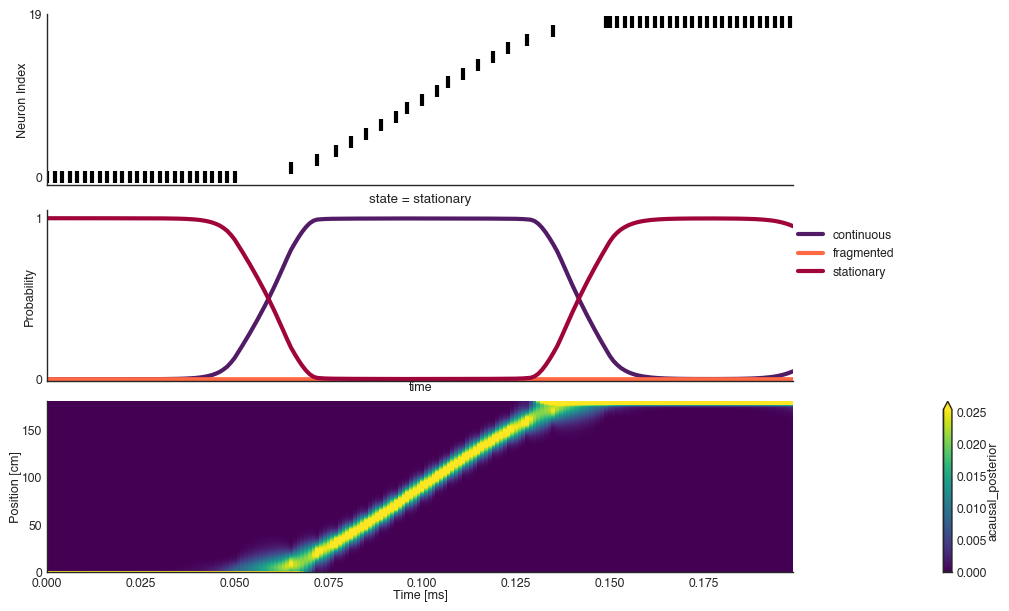

In [12]:
from replay_trajectory_classification.sorted_spikes_simulation import (
    make_hover_continuous_hover_replay,
)

replay_time, test_spikes = make_hover_continuous_hover_replay()

state_names = ["continuous", "fragmented", "stationary"]

fit_args = dict(position=linear_distance, spikes=spikes)
predict_args = dict(spikes=test_spikes, time=replay_time, state_names=state_names)
results, data_log_likelihoods = classifier.estimate_parameters(
    fit_args, predict_args, max_iter=20
)
classifier.plot_discrete_state_transition(state_names=state_names)
plot_classification(replay_time, test_spikes, results)


INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting continuous state transition...
INFO:replay_trajectory_classification.classifier:Fitting discrete state transition
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/19 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:iteration 0, likelihood: -339.6042785644531
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:iteration 1, likelihood: -332.36773681640625, change: 7.236541748046875
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:iteration 2, likelihood: -332.08099365234375, change: 0.2867431640625
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_

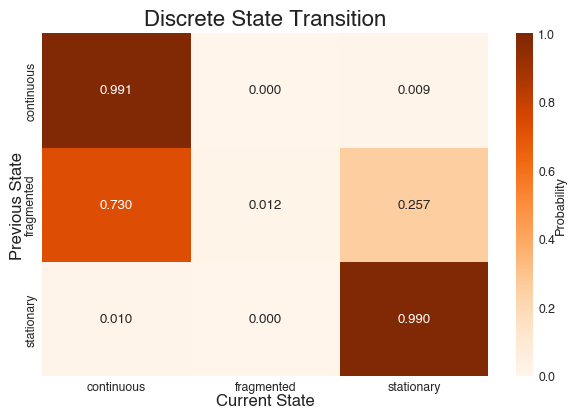

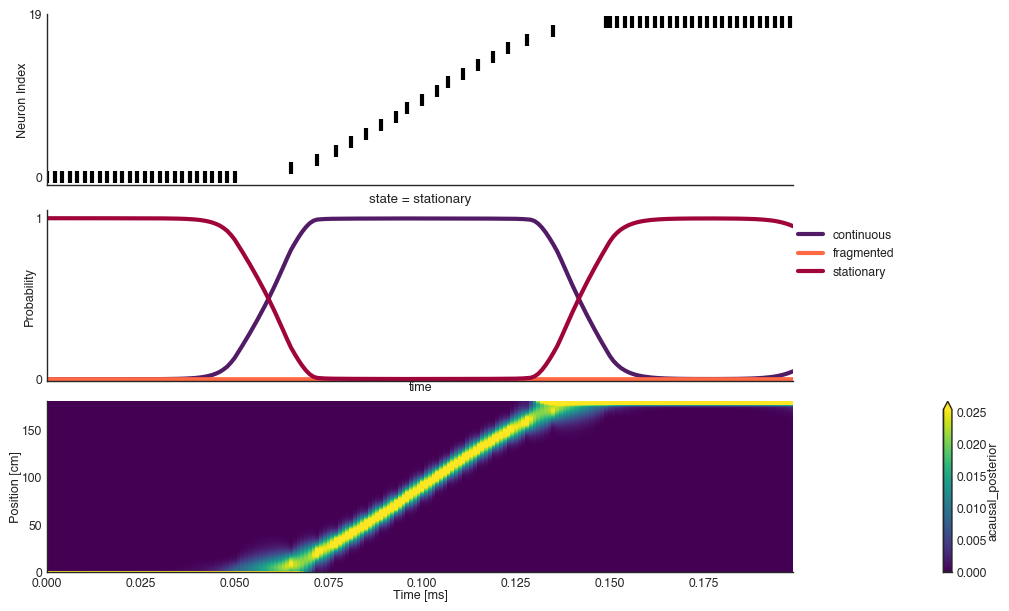

In [13]:
from replay_trajectory_classification.sorted_spikes_simulation import (
    make_fragmented_continuous_fragmented_replay,
)

replay_time, test_spikes = make_hover_continuous_hover_replay()

state_names = ["continuous", "fragmented", "stationary"]

fit_args = dict(position=linear_distance, spikes=spikes)
predict_args = dict(spikes=test_spikes, time=replay_time, state_names=state_names)
results, data_log_likelihoods = classifier.estimate_parameters(
    fit_args, predict_args, max_iter=20
)
classifier.plot_discrete_state_transition(state_names=state_names)
plot_classification(replay_time, test_spikes, results)


INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting continuous state transition...
INFO:replay_trajectory_classification.classifier:Fitting discrete state transition
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/19 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:iteration 0, likelihood: -196.04592895507812
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:iteration 1, likelihood: -193.39202880859375, change: 2.653900146484375
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:iteration 2, likelihood: -193.30799865722656, change: 0.0840301513671875
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_traject

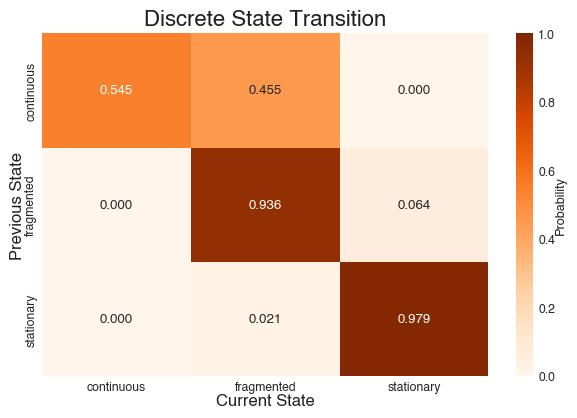

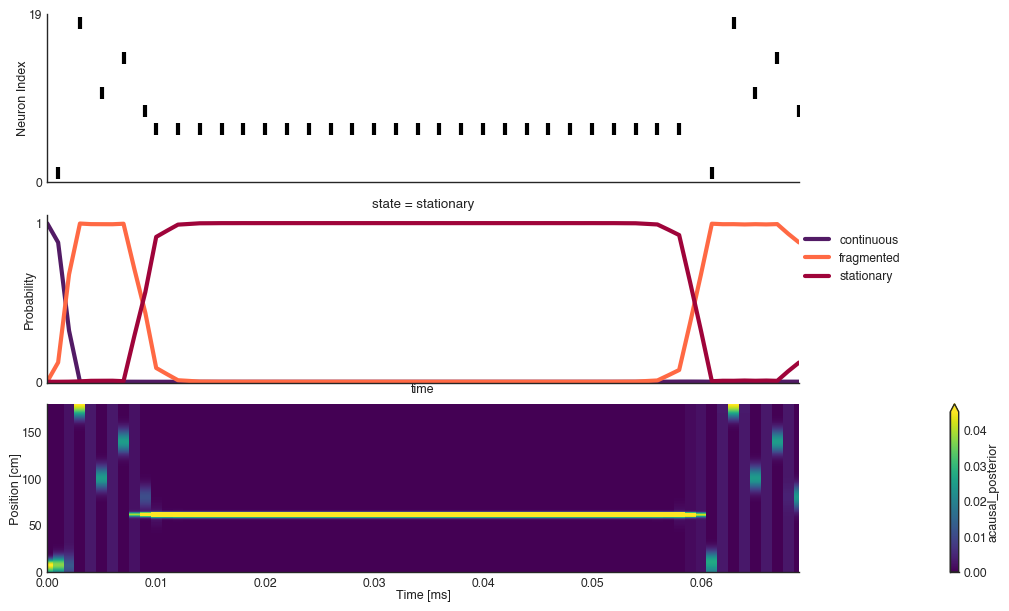

In [14]:
from replay_trajectory_classification.sorted_spikes_simulation import (
    make_fragmented_hover_fragmented_replay,
)

replay_time, test_spikes = make_fragmented_hover_fragmented_replay()

state_names = ["continuous", "fragmented", "stationary"]

fit_args = dict(position=linear_distance, spikes=spikes)
predict_args = dict(spikes=test_spikes, time=replay_time, state_names=state_names)
results, data_log_likelihoods = classifier.estimate_parameters(
    fit_args, predict_args, max_iter=20
)
classifier.plot_discrete_state_transition(state_names=state_names)
plot_classification(replay_time, test_spikes, results)


INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting continuous state transition...
INFO:replay_trajectory_classification.classifier:Fitting discrete state transition
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/19 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:iteration 0, likelihood: -110.94489288330078
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:iteration 1, likelihood: -106.24147033691406, change: 4.703422546386719
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:iteration 2, likelihood: -105.94291687011719, change: 0.298553466796875
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajecto

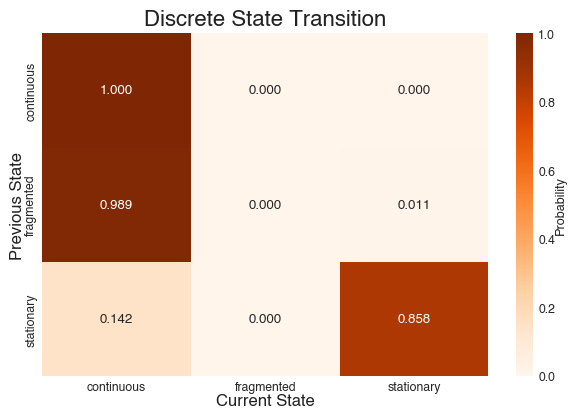

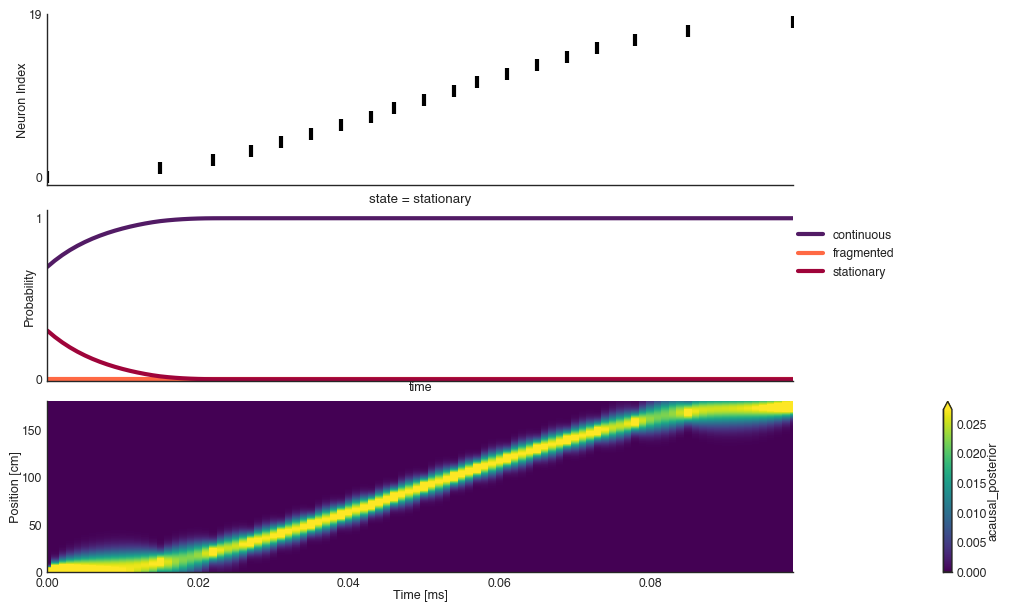

In [15]:
from replay_trajectory_classification.sorted_spikes_simulation import (
    make_continuous_replay,
)

replay_time, test_spikes = make_continuous_replay()

state_names = ["continuous", "fragmented", "stationary"]

fit_args = dict(position=linear_distance, spikes=spikes)
predict_args = dict(spikes=test_spikes, time=replay_time, state_names=state_names)
results, data_log_likelihoods = classifier.estimate_parameters(
    fit_args, predict_args, max_iter=20
)
classifier.plot_discrete_state_transition(state_names=state_names)
plot_classification(replay_time, test_spikes, results)


INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting continuous state transition...
INFO:replay_trajectory_classification.classifier:Fitting discrete state transition
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/19 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:iteration 0, likelihood: -35.219852447509766
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:iteration 1, likelihood: -33.975372314453125, change: 1.2444801330566406
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:iteration 2, likelihood: -33.80059814453125, change: 0.174774169921875
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajecto

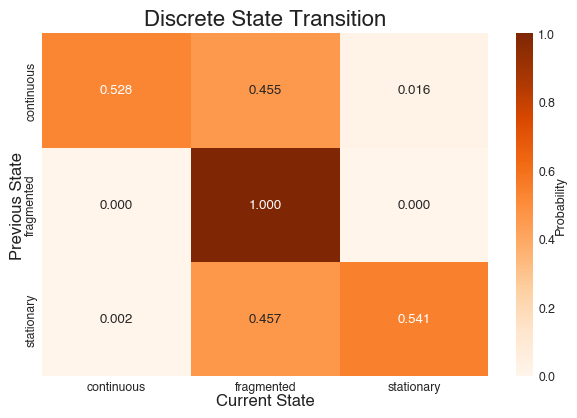

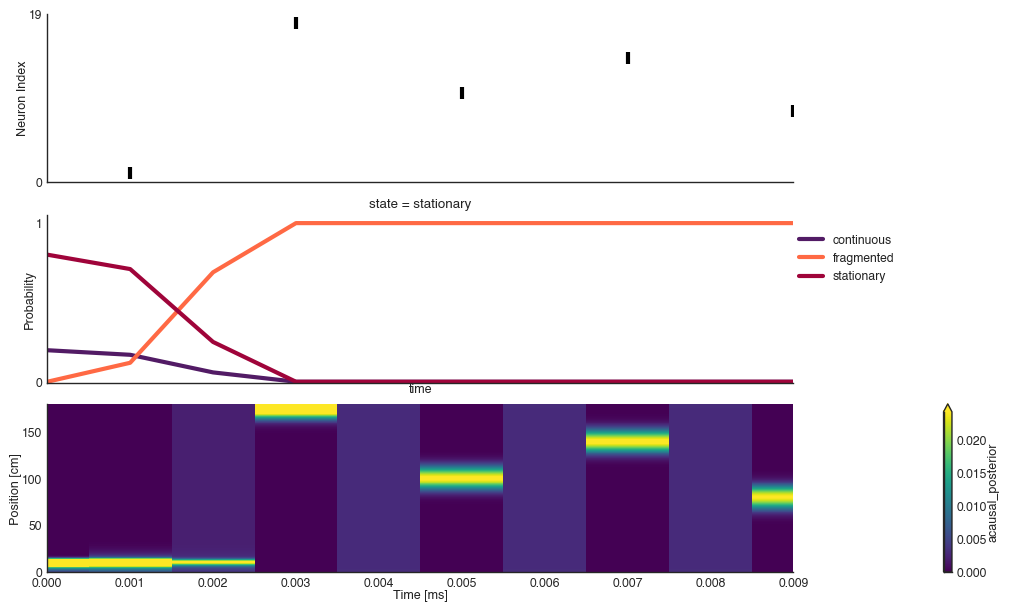

In [16]:
from replay_trajectory_classification.sorted_spikes_simulation import (
    make_fragmented_replay,
)

replay_time, test_spikes = make_fragmented_replay()

state_names = ["continuous", "fragmented", "stationary"]

fit_args = dict(position=linear_distance, spikes=spikes)
predict_args = dict(spikes=test_spikes, time=replay_time, state_names=state_names)
results, data_log_likelihoods = classifier.estimate_parameters(
    fit_args, predict_args, max_iter=20
)
classifier.plot_discrete_state_transition(state_names=state_names)
plot_classification(replay_time, test_spikes, results)


INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting continuous state transition...
INFO:replay_trajectory_classification.classifier:Fitting discrete state transition
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/19 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:iteration 0, likelihood: -121.64903259277344
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:iteration 1, likelihood: -116.35797119140625, change: 5.2910614013671875
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:iteration 2, likelihood: -116.12714385986328, change: 0.23082733154296875
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_traje

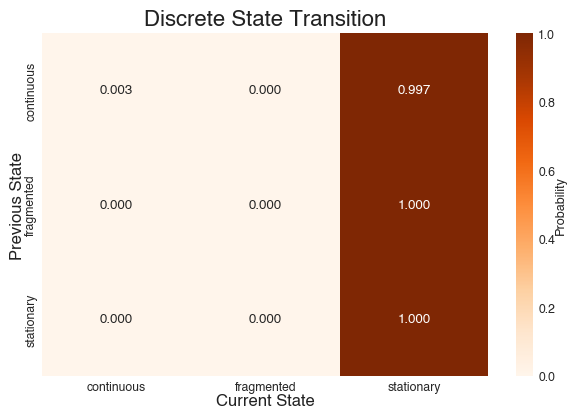

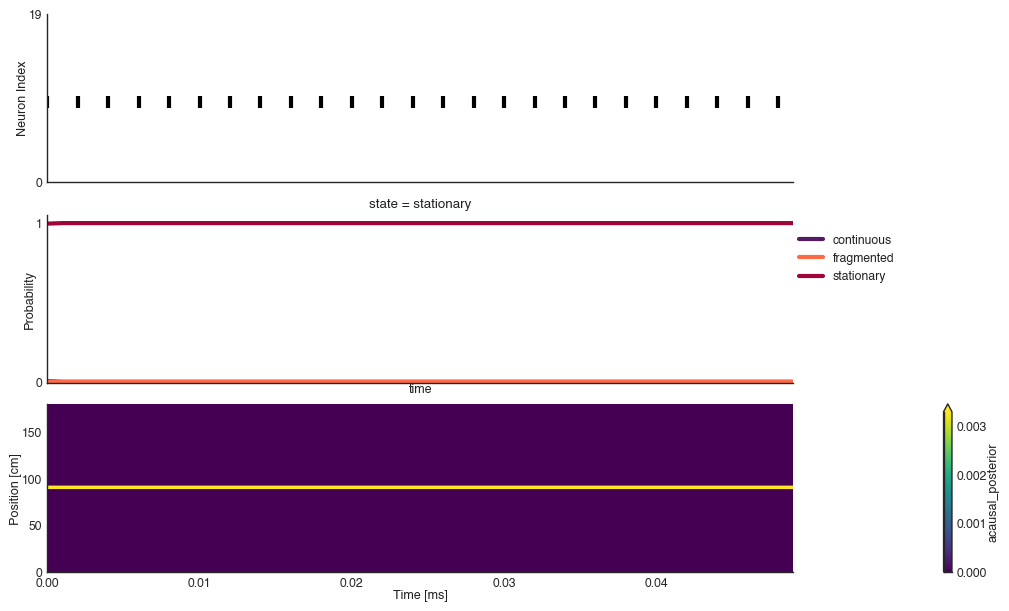

In [17]:
from replay_trajectory_classification.sorted_spikes_simulation import (
    make_hover_replay,
)

replay_time, test_spikes = make_hover_replay()

state_names = ["continuous", "fragmented", "stationary"]

fit_args = dict(position=linear_distance, spikes=spikes)
predict_args = dict(spikes=test_spikes, time=replay_time, state_names=state_names)
results, data_log_likelihoods = classifier.estimate_parameters(
    fit_args, predict_args, max_iter=20
)
classifier.plot_discrete_state_transition(state_names=state_names)
plot_classification(replay_time, test_spikes, results)
